# Pulse Function Tests - Envelope System

This notebook tests the pulse envelope system that supports both cosine² and Gaussian envelopes:
- `envelope_type` parameter in `Pulse` class: 'cos2' or 'gaussian'
- `pulse_peak_time` = time where envelope is maximal
- `pulse_FWHM` = Full Width at Half Maximum parameter
- Pulse exists only in `[t_peak - FWHM, t_peak + FWHM]`
- Easy switching between envelope types via `SystemParameters.envelope_type`

Test scenarios:
- Envelope type comparison
- System-wide envelope control
- Fourier Transform spectral comparison

In [1]:
# =============================
# IMPORT NECESSARY MODULES
# =============================
import numpy as np
import matplotlib.pyplot as plt

# Import from our project
from src.visualization.mpl_tex_settings import *
from src.core.pulse_sequences import PulseSequence, Pulse
from src.core.pulse_functions import (
    pulse_envelope, E_pulse, Epsilon_pulse,
)
from src.core.system_parameters import SystemParameters
from src.visualization.plotting import (
    Plot_pulse_envelope,
    Plot_E_pulse,
    Plot_Epsilon_pulse,
    Plot_all_pulse_components
)

# Set matplotlib parameters for better plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## Test 1: Envelope System - Easy Switching Between Types

Demonstrate how to easily switch between cosine² and Gaussian envelopes using the new system.

ENVELOPE SYSTEM - EASY TYPE SWITCHING

System-wide envelope types:
  Cosine² system: cos2
  Gaussian system: gaussian



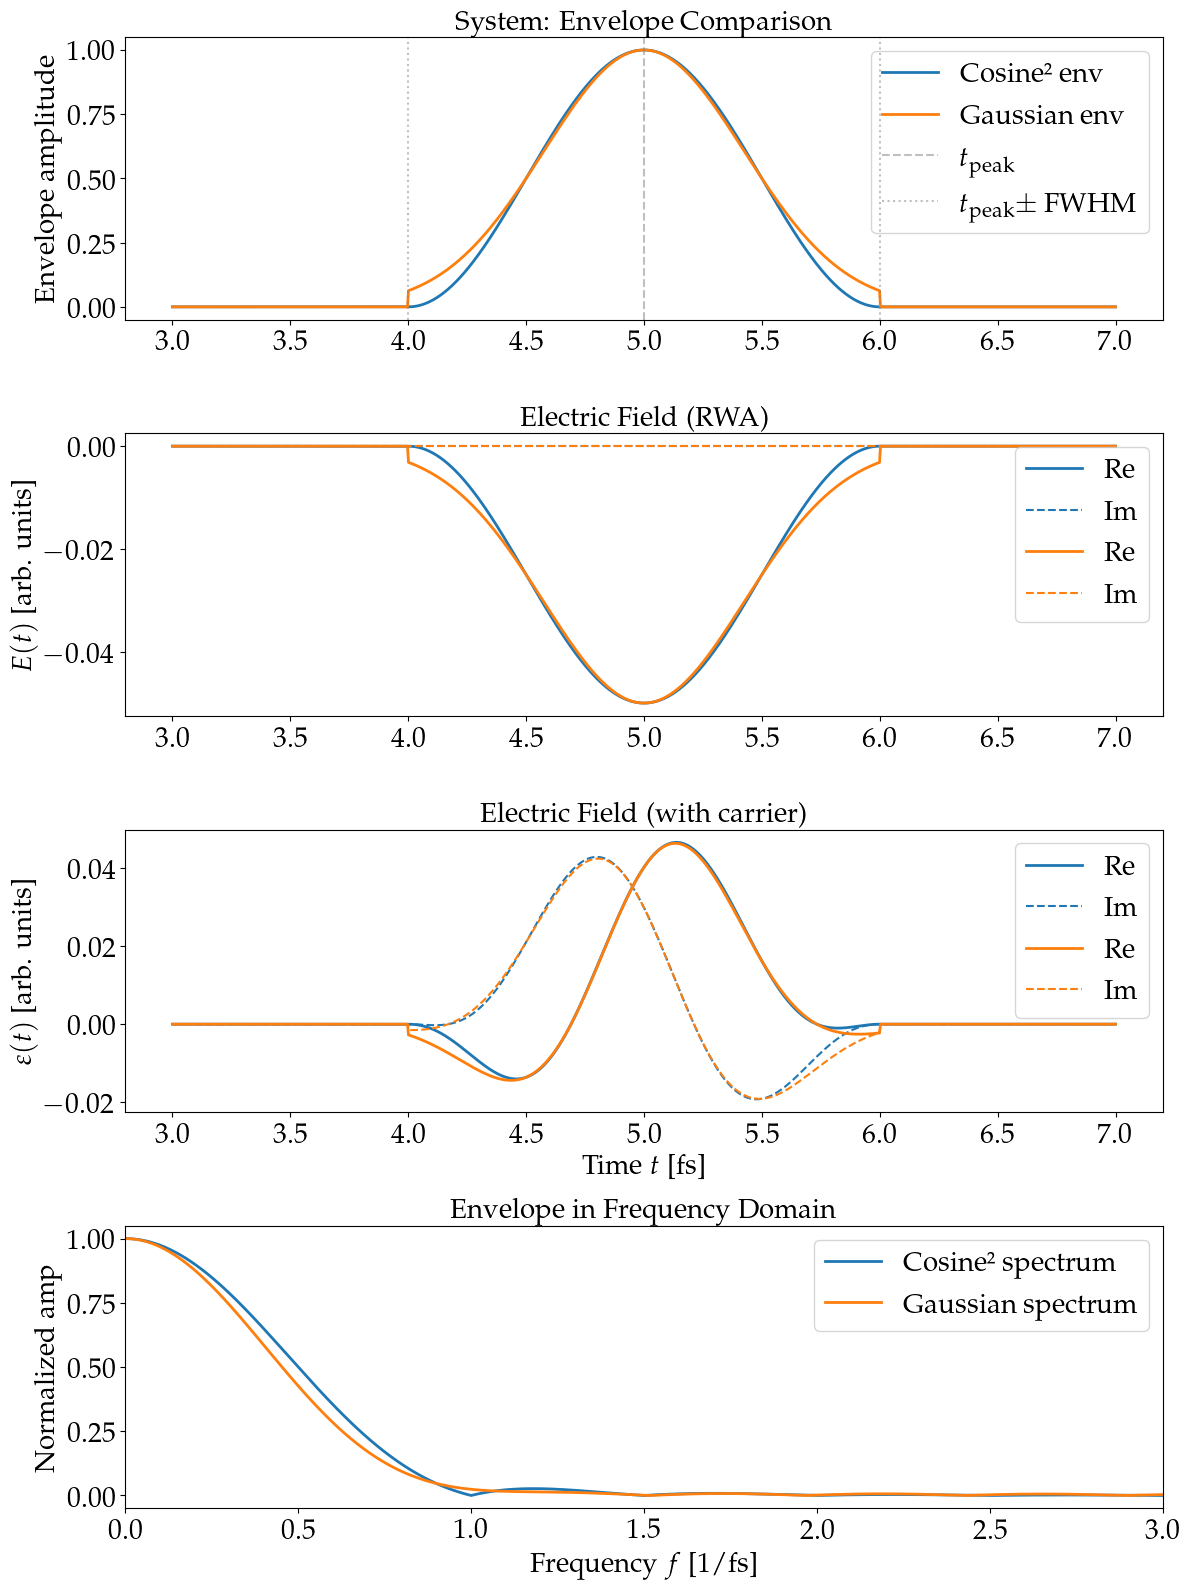

SYSTEM USAGE:
1. Global control:
   SystemParameters(envelope_type="cos2")
2. Individual control:
   Pulse(..., envelope_type="gaussian")
3. functions:
   pulse_envelope
   E_pulse
   Epsilon_pulse
4. Easy switching:
   Change envelope_type parameter

=== SYSTEM BENEFITS ===
✓ Easy switching: just change SystemParameters.envelope_type


In [2]:
# =============================
# ENVELOPE SYSTEM DEMONSTRATION
# =============================
print("=" * 60)
print("ENVELOPE SYSTEM - EASY TYPE SWITCHING")
print("=" * 60)
print()

t_peak = 5.0
FWHM = 1.0
times = np.linspace(t_peak-2*FWHM, t_peak+2*FWHM, 1000)

### Using SystemParameters for global envelope type control
system_cos2 = SystemParameters(pulse_FWHM=FWHM, envelope_type='cos2')
system_gauss = SystemParameters(pulse_FWHM=FWHM, envelope_type='gaussian')

# Create pulse sequence using the system
curr_pulse_params = (t_peak, np.pi)  # (time, phase)
pulse_seq_cos2 = PulseSequence.from_args(system_cos2, curr_pulse_params)
pulse_seq_gauss = PulseSequence.from_args(system_gauss, curr_pulse_params)

print(f"System-wide envelope types:")
print(f"  Cosine² system: {pulse_seq_cos2.pulses[0].envelope_type}")
print(f"  Gaussian system: {pulse_seq_gauss.pulses[0].envelope_type}")
print()

### Calculate envelopes
cos2_envelope = [pulse_envelope(t, pulse_seq_cos2) for t in times]
gauss_envelope = [pulse_envelope(t, pulse_seq_gauss) for t in times]

# =============================
# FOURIER TRANSFORM SPECTRAL ANALYSIS
# =============================
### Create high-resolution time array for accurate FFT
dt = 0.1  # fs (high time resolution)
t_spectral = np.arange(0, 400, dt)  # Extended time range for good frequency resolution
N = len(t_spectral)

### Calculate envelopes
cos2_spectral = np.array([pulse_envelope(t, pulse_seq_cos2) for t in t_spectral])
gauss_spectral = np.array([pulse_envelope(t, pulse_seq_gauss) for t in t_spectral])

### Calculate FFT
freq = np.fft.fftfreq(N, dt)  # frequency in 1/fs
cos2_fft = np.fft.fft(cos2_spectral)
gauss_fft = np.fft.fft(gauss_spectral)

### Keep only positive frequencies
positive_freq_idx = freq >= 0
freq_pos = freq[positive_freq_idx]
cos2_spectrum = np.abs(cos2_fft[positive_freq_idx])
gauss_spectrum = np.abs(gauss_fft[positive_freq_idx])

### Normalize spectra
cos2_spectrum /= np.max(cos2_spectrum)
gauss_spectrum /= np.max(gauss_spectrum)

### Calculate spectral widths (FWHM in frequency domain)
def find_spectral_fwhm(freq_array, spectrum):
    max_val = np.max(spectrum)
    half_max = max_val / 2
    above_half = np.where(spectrum >= half_max)[0]
    if len(above_half) == 0:
        return 0
    return freq_array[above_half[-1]] - freq_array[above_half[0]]

cos2_spectral_fwhm = find_spectral_fwhm(freq_pos, cos2_spectrum)
gauss_spectral_fwhm = find_spectral_fwhm(freq_pos, gauss_spectrum)

### Create combined figure with 4 subplots
fig = plt.figure(figsize=(12, 16))

# First 3 subplots share x-axis (time domain)
ax1 = plt.subplot(4, 1, 1)
ax2 = plt.subplot(4, 1, 2, sharex=ax1)
ax3 = plt.subplot(4, 1, 3, sharex=ax1)
# Fourth subplot has separate x-axis (frequency domain)
ax4 = plt.subplot(4, 1, 4)

# Single envelope comparison
ax1.plot(times, cos2_envelope, label=r'Cosine² env', color='C0', linewidth=2)
ax1.plot(times, gauss_envelope, label='Gaussian env', color='C1', linewidth=2)
ax1.axvline(t_peak, color='gray', linestyle='--', alpha=0.5, label=r'$t_{\text{peak}}$')
ax1.axvline(t_peak - FWHM, color='gray', linestyle=':', alpha=0.5, label=r'$t_{\text{peak}} \pm$ FWHM')
ax1.axvline(t_peak + FWHM, color='gray', linestyle=':', alpha=0.5)
ax1.set_ylabel('Envelope amplitude')
ax1.set_title('System: Envelope Comparison')
ax1.legend()

# Electric field comparison
E_cos2 = [E_pulse(t, pulse_seq_cos2) for t in times]
E_gauss = [E_pulse(t, pulse_seq_gauss) for t in times]
ax2.plot(times, np.real(E_cos2), label=r'$\mathrm{Re}$', color='C0', linestyle='-', linewidth=2)
ax2.plot(times, np.imag(E_cos2), label=r'$\mathrm{Im}$', color='C0', linestyle='--', linewidth=1.5)
ax2.plot(times, np.real(E_gauss), label=r'$\mathrm{Re}$', color='C1', linestyle='-', linewidth=2)
ax2.plot(times, np.imag(E_gauss), label=r'$\mathrm{Im}$', color='C1', linestyle='--', linewidth=1.5)
ax2.set_ylabel(r'$E(t)$ [arb. units]')
ax2.set_title('Electric Field (RWA)')
ax2.legend()

# Full field with carrier
Eps_cos2 = [Epsilon_pulse(t, pulse_seq_cos2) for t in times]
Eps_gauss = [Epsilon_pulse(t, pulse_seq_gauss) for t in times]
ax3.plot(times, np.real(Eps_cos2), label=r'$\mathrm{Re}$', color='C0', linestyle='-', linewidth=2)
ax3.plot(times, np.imag(Eps_cos2), label=r'$\mathrm{Im}$', color='C0', linestyle='--', linewidth=1.5)
ax3.plot(times, np.real(Eps_gauss), label=r'$\mathrm{Re}$', color='C1', linestyle='-', linewidth=2)
ax3.plot(times, np.imag(Eps_gauss), label=r'$\mathrm{Im}$', color='C1', linestyle='--', linewidth=1.5)
ax3.set_xlabel(r'Time $t$ [fs]')
ax3.set_ylabel(r'$\varepsilon(t)$ [arb. units]')
ax3.set_title('Electric Field (with carrier)')
ax3.legend()

# Frequency domain plot
ax4.plot(freq_pos, cos2_spectrum, label=r'Cosine² spectrum', color='C0', linewidth=2)
ax4.plot(freq_pos, gauss_spectrum, label='Gaussian spectrum', color='C1', linewidth=2)
ax4.set_xlim(0, 3)  # Limit to relevant frequency range
ax4.set_xlabel(r'Frequency $f$ [1/fs]')
ax4.set_ylabel('Normalized amp')
ax4.set_title('Envelope in Frequency Domain')
ax4.legend()

plt.tight_layout()
plt.show()

# Usage summary (as normal print statements)
print("SYSTEM USAGE:")
print("1. Global control:")
print("   SystemParameters(envelope_type=\"cos2\")")
print("2. Individual control:")
print("   Pulse(..., envelope_type=\"gaussian\")")
print("3. functions:")
print("   pulse_envelope")
print("   E_pulse")
print("   Epsilon_pulse")
print("4. Easy switching:")
print("   Change envelope_type parameter")

print(f"\n=== SYSTEM BENEFITS ===")
print(f"✓ Easy switching: just change SystemParameters.envelope_type")